In [2]:
import numpy as np  
import glob, os, sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
files = {'siteinfo': 'cosmoz_site_info.csv',
        'Parameters': 'API_parameters.csv',
        'SMAP': 'SMAP_soilmoisture_cosmoz_2019-2020.csv',
        'Tair': 'Tair_anomaly_cosmoz_climatology.csv',
        'GPM': 'GPM_rainfall_cosmoz_2019-2020.csv'}
def config_ancil(files):
    """
    files: file name for input files
    par: parameters for API and SWI
    sitename: station name for simulations
    dfTair: Tair anomaly
    """
    dfsite = pd.read_csv(files['siteinfo'],index_col=0)
    sites = dfsite[dfsite.Status=='live']
    sitenames = sites.Station_Name.values
    dfpar = pd.read_csv(files['Parameters'])
    dfTair = pd.read_csv(files['Tair'],index_col=0,parse_dates=True)
    
    return dfpar,dfTair,sitenames

In [24]:
def API_timestep(A0,Pt,Tdiff,beta,delta):
    """
    API openloop Run for each day
    A0: API at t-1, 
    Pt: Precipitation at t
    Tdiff: Tair anomaly at t
    beta, delta: beta, delta parameter
    """
    Gamma = beta + delta*Tdiff
    Gamma[Gamma>1]=1
    API = Gamma*A0+Pt
    return API

def SWI_timestep(Kn_p,SWI_p,SSM,T=20):
    """
    Kn_p: Kn at t-1
    SWI_p: SWI at t-1
    SSM: surface soil wetness
    T: parameter to determine the soil depth, by default is 20
    """
    delta_t = 1
    Kn = Kn_p/(Kn_p+np.exp(-(delta_t)/T))
    SWI = SWI_p + Kn*(SSM-SWI_p)

    return SWI,Kn

def SMAP_assimilation(SMAPobs,APIa_p,GPM,Tair,dfpar):
    """
    SMAP variational assimilation using a 4 day window
    i.e. use the SMAP observations from t to t+3 to update the API forecast at t
    SMAPobs: SMAP observations from day t to t+3
    APIa_p: previous API analysis
    GPM: GPM rainfall from day t to t+3
    Tair: Tair anomaly from day t to t+3
    dfpar: parameters
    APIa: API analysis at day t
    
    """
    SMAPmin = dfpar.SMAPmin.values
    SMAPmax = dfpar.SMAPmax.values
    APImin = dfpar.APImin.values
    APImax = dfpar.APImax.values
    SMAPwetness = (SMAPobs-SMAPmin)/(SMAPmax-SMAPmin)
    SMAPwetness[:,(SMAPmax-SMAPmin)==0] = np.nan
    SMAPwetness[SMAPwetness>1]=1
    SMAPwetness[SMAPwetness<0]=0
    SMAPAPI = SMAPwetness*(APImax-APImin)+APImin
    beta = dfpar.beta.values
    delta = dfpar.delta.values
    gamma = (beta+delta*Tair)
    gamma[gamma>1]=1
    y = SMAPAPI.copy()
    y[np.isnan(y)] = 0
    t = 0

    APIf = gamma[t,:]*APIa_p+GPM[t,:]

    M1Xt = gamma[t+1,:]*APIf+GPM[t+1,:]
    M2Xt = gamma[t+2,:]*gamma[t+1,:]*APIf+gamma[t+2,:]*GPM[t+1,:] + GPM[t+2,:]
    M3Xt = gamma[t+3,:]*gamma[t+2,:]*gamma[t+1,:]*APIf+gamma[t+3,:]*gamma[t+2,:]*GPM[t+1,:] + gamma[t+3,:]*GPM[t+2,:]+GPM[t+3,:]

    denominator = 1 + ~np.isnan(SMAPAPI[t,:])*1 + ~np.isnan(SMAPAPI[t+1,:])*gamma[t+1,:]**2 + ~np.isnan(SMAPAPI[t+2,:])*(gamma[t+2,:]*gamma[t+1,:])**2 + ~np.isnan(SMAPAPI[t+3,:])*(gamma[t+3,:]*gamma[t+2,:]*gamma[t+1,:])**2

    numerator = ~np.isnan(SMAPAPI[t,:])*(y[t,:]-APIf) + ~np.isnan(SMAPAPI[t+1,:])*gamma[t+1,:]*(y[t+1,:]-M1Xt) + ~np.isnan(SMAPAPI[t+2,:])*gamma[t+2,:]*gamma[t+1,:]*(y[t+2,:]-M2Xt) +  ~np.isnan(SMAPAPI[t+3,:])*gamma[t+3,:]*gamma[t+2,:]*gamma[t+1,:]*(y[t+3,:]-M3Xt)

    APIa = APIf + numerator/denominator
    APIa[APIa<0] = 0
    
    return APIa

In [36]:
period = pd.date_range('2019-01-01','2020-12-31') # 4 day window assimilation, need the obs for the next 3 days, so the demo finishes at 12-29
dfpar,dfTair,sitenames = config_ancil(files)
GPMobs = pd.read_csv('GPM_rainfall_cosmoz_2019-2020.csv',parse_dates=True,index_col=0)
SMAPobs = pd.read_csv('SMAP_soilmoisture_cosmoz_2019-2020.csv',parse_dates=True,index_col=0)
API = np.zeros((len(period),len(sitenames)))*np.nan #openloop
SSM = np.zeros((len(period),len(sitenames)))*np.nan #surface SM wetness
SWI = np.zeros((len(period),len(sitenames)))*np.nan #root-zone SM wetness, openloop
APIa = np.zeros((len(period),len(sitenames)))*np.nan #after DA
SSMa = np.zeros((len(period),len(sitenames)))*np.nan #after DA
SWIa = np.zeros((len(period),len(sitenames)))*np.nan #root-zone SM wetness, after DA
#initialization of API and Kn
API_p = np.zeros((len(sitenames)))
SWI_p = np.zeros((len(sitenames)))
Kn_p = np.ones((len(sitenames)))
APIa_p = np.zeros((len(sitenames)))
SWIa_p = np.zeros((len(sitenames)))
for di,date in enumerate(period):
    print("calculate API and SWI for %s" %date)
    Pt = GPMobs.iloc[di].values
    dayofyear = date.dayofyear
    Tdiff = dfTair.iloc[dayofyear-1].values 
    # calculate the API open-loop
    API[di,:] = API_timestep(API_p,Pt,Tdiff,dfpar.beta.values,dfpar.delta.values)
    API_p = API[di,:]
    # convert the API analysis to wetness
    SSM[di,:]= (API[di,:]-dfpar.APImin.values)/(dfpar.APImax.values-dfpar.APImin.values)
    # calculate the SWI open-loop
    SWI[di,:],Kn = SWI_timestep(Kn_p,SWI_p,SSM[di,:],T=20)  
    SWI_p = SWI[di,:]

    # assimilation of SMAP data using 4 day moving window
    if di+3 <len(period):
        SMAP = SMAPobs.iloc[di:di+4,:].values
        GPM = GPMobs.iloc[di:di+4,:].values
        if dayofyear+3<366:
            Tair = dfTair.iloc[dayofyear-1:dayofyear+3,:].values
        elif (dayofyear+3>=366 and dayofyear!=366):
            daymin = np.min([dayofyear+3,365])
            tmp = dfTair.iloc[dayofyear-1:daymin,:].values
            Tair = np.concatenate([tmp,dfTair.iloc[0:4-tmp.shape[0],:].values])
        else:
            tmp = dfTair.iloc[dayofyear-1:dayofyear,:].values
            Tair = np.concatenate([tmp,dfTair.iloc[0:4-tmp.shape[0],:].values])
        
        APIa[di,:] = SMAP_assimilation(SMAP,APIa_p,GPM,Tair,dfpar)
        APIa_p = APIa[di,:]
        SSMa[di,:] = (APIa[di,:]-dfpar.APImin.values)/(dfpar.APImax.values-dfpar.APImin.values)
        SWIa[di,:],Kn = SWI_timestep(Kn_p,SWIa_p,SSMa[di,:],T=20)
        SWIa_p = SWIa[di,:]
       
    Kn_p = Kn

calculate API and SWI for 2019-01-01 00:00:00
calculate API and SWI for 2019-01-02 00:00:00
calculate API and SWI for 2019-01-03 00:00:00
calculate API and SWI for 2019-01-04 00:00:00
calculate API and SWI for 2019-01-05 00:00:00
calculate API and SWI for 2019-01-06 00:00:00
calculate API and SWI for 2019-01-07 00:00:00
calculate API and SWI for 2019-01-08 00:00:00
calculate API and SWI for 2019-01-09 00:00:00
calculate API and SWI for 2019-01-10 00:00:00
calculate API and SWI for 2019-01-11 00:00:00
calculate API and SWI for 2019-01-12 00:00:00
calculate API and SWI for 2019-01-13 00:00:00
calculate API and SWI for 2019-01-14 00:00:00
calculate API and SWI for 2019-01-15 00:00:00
calculate API and SWI for 2019-01-16 00:00:00
calculate API and SWI for 2019-01-17 00:00:00
calculate API and SWI for 2019-01-18 00:00:00
calculate API and SWI for 2019-01-19 00:00:00
calculate API and SWI for 2019-01-20 00:00:00
calculate API and SWI for 2019-01-21 00:00:00
calculate API and SWI for 2019-01-

calculate API and SWI for 2019-08-02 00:00:00
calculate API and SWI for 2019-08-03 00:00:00
calculate API and SWI for 2019-08-04 00:00:00
calculate API and SWI for 2019-08-05 00:00:00
calculate API and SWI for 2019-08-06 00:00:00
calculate API and SWI for 2019-08-07 00:00:00
calculate API and SWI for 2019-08-08 00:00:00
calculate API and SWI for 2019-08-09 00:00:00
calculate API and SWI for 2019-08-10 00:00:00
calculate API and SWI for 2019-08-11 00:00:00
calculate API and SWI for 2019-08-12 00:00:00
calculate API and SWI for 2019-08-13 00:00:00
calculate API and SWI for 2019-08-14 00:00:00
calculate API and SWI for 2019-08-15 00:00:00
calculate API and SWI for 2019-08-16 00:00:00
calculate API and SWI for 2019-08-17 00:00:00
calculate API and SWI for 2019-08-18 00:00:00
calculate API and SWI for 2019-08-19 00:00:00
calculate API and SWI for 2019-08-20 00:00:00
calculate API and SWI for 2019-08-21 00:00:00
calculate API and SWI for 2019-08-22 00:00:00
calculate API and SWI for 2019-08-

calculate API and SWI for 2020-06-02 00:00:00
calculate API and SWI for 2020-06-03 00:00:00
calculate API and SWI for 2020-06-04 00:00:00
calculate API and SWI for 2020-06-05 00:00:00
calculate API and SWI for 2020-06-06 00:00:00
calculate API and SWI for 2020-06-07 00:00:00
calculate API and SWI for 2020-06-08 00:00:00
calculate API and SWI for 2020-06-09 00:00:00
calculate API and SWI for 2020-06-10 00:00:00
calculate API and SWI for 2020-06-11 00:00:00
calculate API and SWI for 2020-06-12 00:00:00
calculate API and SWI for 2020-06-13 00:00:00
calculate API and SWI for 2020-06-14 00:00:00
calculate API and SWI for 2020-06-15 00:00:00
calculate API and SWI for 2020-06-16 00:00:00
calculate API and SWI for 2020-06-17 00:00:00
calculate API and SWI for 2020-06-18 00:00:00
calculate API and SWI for 2020-06-19 00:00:00
calculate API and SWI for 2020-06-20 00:00:00
calculate API and SWI for 2020-06-21 00:00:00
calculate API and SWI for 2020-06-22 00:00:00
calculate API and SWI for 2020-06-

Text(0.5, 1.0, 'Daly')

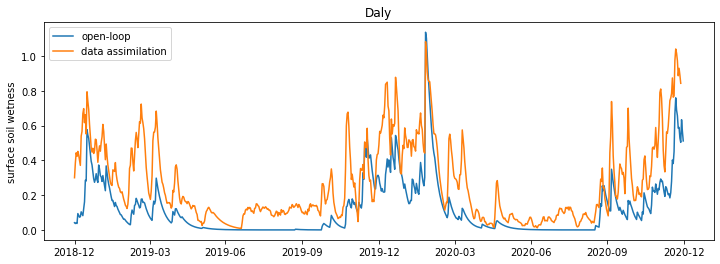

In [37]:
#plot the SSM open-loop and SSM after DA for site0
plt.figure(figsize=(12,4))
plt.plot(period,SSM[:,0],label='open-loop')
plt.plot(period,SSMa[:,0],label='data assimilation')
plt.ylabel('surface soil wetness')
plt.legend()
plt.title(sitenames[0])

Text(0.5, 1.0, 'Daly')

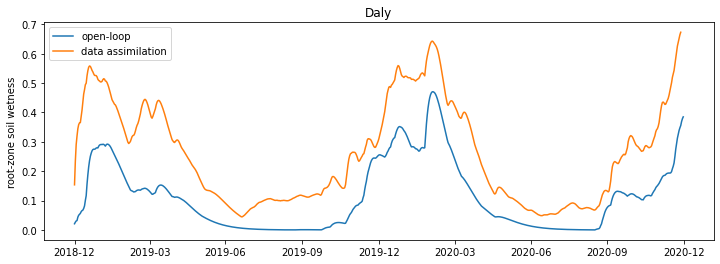

In [38]:
#plot the RZSM open-loop and RZSM after DA for site0
plt.figure(figsize=(12,4))
plt.plot(period,SWI[:,0],label='open-loop')
plt.plot(period,SWIa[:,0],label='data assimilation')
plt.ylabel('root-zone soil wetness')
plt.legend()
plt.title(sitenames[0])